In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import date
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.proportion import proportions_ztest

In [6]:
#load data
df = pd.read_csv('logs_exp_us.csv', sep='\t')

In [7]:
# Dataset info
print("Dataset info:")
print(df.info())
print("\nFirst lines:")
print(df.head())
print("\nColumns names:")
print(df.columns.tolist())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None

First lines:
                 EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
3         CartScreenAppear  3518123091307005509      1564054127    248
4  PaymentScreenSuccessful  6217807653094995999      1564055322    248

Columns names:
['EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId']


In [8]:
# Translate columns 
df.columns = df.columns.str.lower()
print(df.columns.tolist())

['eventname', 'deviceidhash', 'eventtimestamp', 'expid']


In [9]:
# Detailed information about data types and missing values
print("=== INFORMACIÓN GENERAL ===")
print(f"dataset shape: {df.shape}")
print(f"Total records: {len(df)}")

print("\n=== Data type ===")
print(df.dtypes)

print("\n=== Absent values ===")
print("Null values per column:")
print(df.isnull().sum())

print("\n=== Unique values ===")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

=== INFORMACIÓN GENERAL ===
dataset shape: (244126, 4)
Total records: 244126

=== Data type ===
eventname         object
deviceidhash       int64
eventtimestamp     int64
expid              int64
dtype: object

=== Absent values ===
Null values per column:
eventname         0
deviceidhash      0
eventtimestamp    0
expid             0
dtype: int64

=== Unique values ===
eventname: 5 unique values
deviceidhash: 7551 unique values
eventtimestamp: 176654 unique values
expid: 3 unique values


In [10]:
# Examine each column in detail
print("=== ANALYSIS PER COLUMN ===")

print("\n1. EVENTNAME:")
print(df['eventname'].value_counts())

print("\n2. EXPID (experimental groups):")
print(df['expid'].value_counts())

print("\n3. EVENTTIMESTAMP:")
print(f"Timestamps rate: {df['eventtimestamp'].min()} - {df['eventtimestamp'].max()}")

print("\n4. DEVICEIDHASH:")
print(f"Unique users: {df['deviceidhash'].nunique()}")

=== ANALYSIS PER COLUMN ===

1. EVENTNAME:
eventname
MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: count, dtype: int64

2. EXPID (experimental groups):
expid
248    85747
246    80304
247    78075
Name: count, dtype: int64

3. EVENTTIMESTAMP:
Timestamps rate: 1564029816 - 1565212517

4. DEVICEIDHASH:
Unique users: 7551


In [11]:
# traslate timestamp Unix a datetime
df['eventtimestamp'] = pd.to_datetime(df['eventtimestamp'], unit='s')

# check conversion

print("date rate:")
print(f"Since: {df['eventtimestamp'].min()}")
print(f"to: {df['eventtimestamp'].max()}")
print(f"During: {(df['eventtimestamp'].max() - df['eventtimestamp'].min()).days} days")


date rate:
Since: 2019-07-25 04:43:36
to: 2019-08-07 21:15:17
During: 13 days


In [12]:
# New date column without time
df['date'] = df['eventtimestamp'].dt.date

# Distribution per date
print("\nEvents per date (first 5 days):")
print(df['date'].value_counts().sort_index().head(10))
print(df.head(3))


Events per date (first 5 days):
date
2019-07-25        9
2019-07-26       31
2019-07-27       55
2019-07-28      105
2019-07-29      184
2019-07-30      413
2019-07-31     2031
2019-08-01    36229
2019-08-02    35606
2019-08-03    33351
Name: count, dtype: int64
                 eventname         deviceidhash      eventtimestamp  expid  \
0         MainScreenAppear  4575588528974610257 2019-07-25 04:43:36    246   
1         MainScreenAppear  7416695313311560658 2019-07-25 11:11:42    246   
2  PaymentScreenSuccessful  3518123091307005509 2019-07-25 11:28:47    248   

         date  
0  2019-07-25  
1  2019-07-25  
2  2019-07-25  


In [13]:
# Verify sell funnel
print("\n=== Sells funnel ===")
funnel_events = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

for event in funnel_events:
    count = df[df['eventname'] == event].shape[0]
    users = df[df['eventname'] == event]['deviceidhash'].nunique()
    print(f"{event}: {count} events, {users} unique users")


=== Sells funnel ===


MainScreenAppear: 119205 events, 7439 unique users
OffersScreenAppear: 46825 events, 4613 unique users
CartScreenAppear: 42731 events, 3749 unique users
PaymentScreenSuccessful: 34313 events, 3547 unique users


In [14]:
print(f"Unique users: {df['deviceidhash'].nunique()}")

Unique users: 7551


In [15]:
# Calculate avg events per user each group
print("=== Average events per user in each group===")
for group in df['expid'].unique():
    # Filter data per group
    group_data = df[df['expid'] == group]
    
    # Calculate average events per user
    total_events = len(group_data)
    unique_users = group_data['deviceidhash'].nunique()
    avg_events = total_events / unique_users
    
    print(f"Group {group}: {avg_events:.2f} avg events per user")
    print(f"  - Total events: {total_events:,}")
    print(f"  - Unique users: {unique_users:,}")
    print()

=== Average events per user in each group===
Group 246: 32.26 avg events per user
  - Total events: 80,304
  - Unique users: 2,489



Group 248: 33.73 avg events per user
  - Total events: 85,747
  - Unique users: 2,542

Group 247: 30.98 avg events per user
  - Total events: 78,075
  - Unique users: 2,520



In [16]:
# find max and min dates
print("date rate:")
print(f"Since: {df['eventtimestamp'].min()}")
print(f"To: {df['eventtimestamp'].max()}")
print(f"During: {(df['eventtimestamp'].max() - df['eventtimestamp'].min()).days} days")


date rate:
Since: 2019-07-25 04:43:36
To: 2019-08-07 21:15:17
During: 13 days


In [17]:
# Events per day
daily_events = df['date'].value_counts().sort_index()
print("\n=== EVENTS PER DAY ===")
print(daily_events)


=== EVENTS PER DAY ===
date
2019-07-25        9
2019-07-26       31
2019-07-27       55
2019-07-28      105
2019-07-29      184
2019-07-30      413
2019-07-31     2031
2019-08-01    36229
2019-08-02    35606
2019-08-03    33351
2019-08-04    33033
2019-08-05    36113
2019-08-06    35822
2019-08-07    31144
Name: count, dtype: int64


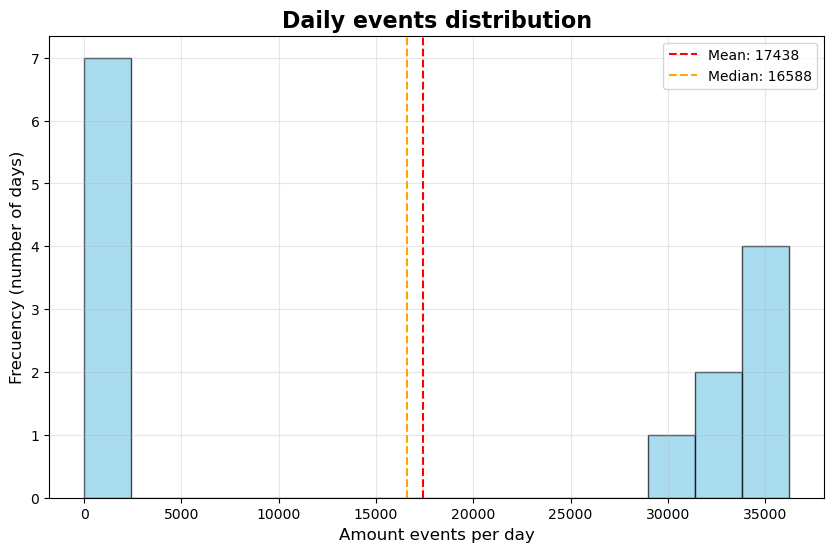

In [18]:
plt.figure(figsize=(10, 6))
daily_events.hist(bins=15, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Daily events distribution', fontsize=16, fontweight='bold')
plt.xlabel('Amount events per day', fontsize=12)
plt.ylabel('Frecuency (number of days)', fontsize=12)

# Add vertical lines for mean and median
plt.axvline(daily_events.mean(), color='red', linestyle='--', 
           label=f'Mean: {daily_events.mean():.0f}')
plt.axvline(daily_events.median(), color='orange', linestyle='--', 
           label=f'Median: {daily_events.median():.0f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [19]:
df['expid'].value_counts()

expid
248    85747
246    80304
247    78075
Name: count, dtype: int64

In [20]:
# Sum events from 25 to 31 july
start_date= date(2019, 7, 25)
end_date= date(2019, 7, 30)
events_first_days = daily_events[start_date : end_date].sum()
print(f"Events 25-30 july: {events_first_days:,}")

Events 25-30 july: 797


In [21]:
# Total events during all the test
total_events = daily_events.sum()
print(f"Total events (25 jul - 7 ago): {total_events:,}")

# Percentage represented by the first few days
percentage_lost = (events_first_days / total_events) * 100
print(f"Percentage lost: {percentage_lost:.2f}%")

Total events (25 jul - 7 ago): 244,126
Percentage lost: 0.33%


##### Noting that the period from July 25 to July 31 represents more of a launch period, since all these values only represent 0.33% of the sample.

In [22]:
# Complete analysis of events by frequency
print("=== Analysis of events by frequency ===")
event_counts = df['eventname'].value_counts()
print("\nEvents sorted by frequency:")
print(event_counts)

=== Analysis of events by frequency ===

Events sorted by frequency:
eventname
MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: count, dtype: int64


In [23]:

print("\nPercentage of each event:")
event_percentages = (event_counts / len(df) * 100).round(2)
for event, percentage in event_percentages.items():
    print(f"{event}: {percentage}%")

print(f"\nTotal unique events: {df['eventname'].nunique()}")
print(f"Total records: {len(df):,}")


Percentage of each event:
MainScreenAppear: 48.83%
OffersScreenAppear: 19.18%
CartScreenAppear: 17.5%
PaymentScreenSuccessful: 14.06%
Tutorial: 0.43%

Total unique events: 5
Total records: 244,126


In [24]:
# Analysis unique users per event
print("=== Unique users per event ===")
users_per_event = df.groupby('eventname')['deviceidhash'].nunique().sort_values(ascending=False)
print("\nEvents sorted by number of unique users:")
print(users_per_event)

=== Unique users per event ===

Events sorted by number of unique users:
eventname
MainScreenAppear           7439
OffersScreenAppear         4613
CartScreenAppear           3749
PaymentScreenSuccessful    3547
Tutorial                    847
Name: deviceidhash, dtype: int64


In [25]:
# Calculate the proportions of users who performed each action
total_users = df['deviceidhash'].nunique()
print(f"unique users: {total_users:,}")

print("\n=== USER PROPORTIONS BY EVENT ===")
user_proportions = (users_per_event / total_users * 100).round(2)

for event, count in users_per_event.items():
    proportion = user_proportions[event]
    print(f"{event}: {count:,} users ({proportion}%)")

unique users: 7,551

=== USER PROPORTIONS BY EVENT ===
MainScreenAppear: 7,439 users (98.52%)
OffersScreenAppear: 4,613 users (61.09%)
CartScreenAppear: 3,749 users (49.65%)
PaymentScreenSuccessful: 3,547 users (46.97%)
Tutorial: 847 users (11.22%)


In [26]:
# convertion rate from MainScreen to PaymentScreenSuccessful
convertion_rate = (3547 / 7439) * 100
print(f"The convertion rate form the main screen to the succes payment is : {convertion_rate:.2f}%")

The convertion rate form the main screen to the succes payment is : 47.68%


In [27]:
# Complete conversion funnel analysis
print("=== conversion funnel analysis ===")

# Calculate conversion rates step by step
main_users = users_per_event['MainScreenAppear']
offers_users = users_per_event['OffersScreenAppear'] 
cart_users = users_per_event['CartScreenAppear']
payment_users = users_per_event['PaymentScreenSuccessful']

print(f"MainScreen → Offers: {offers_users/main_users*100:.2f}%")
print(f"Offers → Cart: {cart_users/offers_users*100:.2f}%")
print(f"Cart → Payment: {payment_users/cart_users*100:.2f}%")
print(f"MainScreen → Payment (total): {payment_users/main_users*100:.2f}%")

=== conversion funnel analysis ===
MainScreen → Offers: 62.01%
Offers → Cart: 81.27%
Cart → Payment: 94.61%
MainScreen → Payment (total): 47.68%


From MainScreen to Offers, 37.99% of users are lost (100% - 62.01%).

From Offers to Cart, 18.73% of users are lost (100% - 81.27%).

From Cart to Payment, 5.39% of users are lost (100% - 94.61%).

##### Stage A of MainScreen to Offers is where the highest number of users are lost (38%), and we can see that a total of 47.68% complete the entire journey from Main Screen to Payment.

In [28]:
print("\n=== USER PROPORTIONS BY EVENT ===")
user_proportions = (users_per_event / total_users * 100).round(2)

for event, count in users_per_event.items():
    proportion = user_proportions[event]
    print(f"{event}: {count:,} users ({proportion}%)")


=== USER PROPORTIONS BY EVENT ===
MainScreenAppear: 7,439 users (98.52%)
OffersScreenAppear: 4,613 users (61.09%)
CartScreenAppear: 3,749 users (49.65%)
PaymentScreenSuccessful: 3,547 users (46.97%)
Tutorial: 847 users (11.22%)


In [29]:
grup_246 = df[df['expid'] == 246]
grup_247 = df[df['expid'] == 247]

print(grup_246.shape)
print(grup_247.shape)

(80304, 5)
(78075, 5)


In [30]:
# Analysis of the most popular event by group
print("\n=== MAINSCREENAPPEAR PER GRUP ===")
main_screen_by_group = grup_246[grup_246['eventname'] == 'MainScreenAppear'].groupby('expid')['deviceidhash'].nunique()
print("Users who performed MainScreenAppear by group")
print(main_screen_by_group)


=== MAINSCREENAPPEAR PER GRUP ===
Users who performed MainScreenAppear by group
expid
246    2456
Name: deviceidhash, dtype: int64


In [31]:
# Crear la variable users_per_group
users_per_group = df.groupby('expid')['deviceidhash'].nunique()
print("Usuarios únicos por grupo experimental:")
print(users_per_group)

Usuarios únicos por grupo experimental:
expid
246    2489
247    2520
248    2542
Name: deviceidhash, dtype: int64


In [32]:
# Check whether the distribution is balanced
total_users = grup_246['deviceidhash'].nunique()
print(f"\nTotal unique users: {total_users}")
print("\nProportion per group:")
for group, count in users_per_group.items():
    proportion = (count / total_users * 100)
    print(f"Group {group}: {count} users ({proportion:.2f}%)")


Total unique users: 2489

Proportion per group:
Group 246: 2489 users (100.00%)
Group 247: 2520 users (101.25%)
Group 248: 2542 users (102.13%)


In [33]:
print("\n=== MAINSCREENAPPEAR PER GRUP ===")
main_screen_by_group = df[df['eventname'] == 'MainScreenAppear'].groupby('expid')['deviceidhash'].nunique()
print("Users who performed MainScreenAppear by group:")
print(main_screen_by_group)


=== MAINSCREENAPPEAR PER GRUP ===
Users who performed MainScreenAppear by group:
expid
246    2456
247    2482
248    2501
Name: deviceidhash, dtype: int64


In [34]:

print("\nProportions:")
for group in users_per_group.index:
    users_in_group = users_per_group[group]
    users_with_event = main_screen_by_group.get(group, 0)
    proportion = (users_with_event / users_in_group * 100)
    print(f"Group {group}: {users_with_event}/{users_in_group} = {proportion:.2f}%")



Proportions:
Group 246: 2456/2489 = 98.67%
Group 247: 2482/2520 = 98.49%
Group 248: 2501/2542 = 98.39%


In [35]:
# Complete analysis of events by experimental group
print("=== DISTRIBUTION OF ALL EVENTS BY GROUP ===")
event_group_analysis = df.groupby(['expid', 'eventname'])['deviceidhash'].nunique().unstack(fill_value=0)
print(event_group_analysis)

=== DISTRIBUTION OF ALL EVENTS BY GROUP ===


eventname  CartScreenAppear  MainScreenAppear  OffersScreenAppear  \
expid                                                               
246                    1270              2456                1545   
247                    1240              2482                1530   
248                    1239              2501                1538   

eventname  PaymentScreenSuccessful  Tutorial  
expid                                         
246                           1202       279  
247                           1160       286  
248                           1185       282  


In [36]:
#  Calculate percentages of users per event and group
print("\n=== PERCENTAGES OF USERS BY EVENT AND GROUP ===")
for group in users_per_group.index:
    print(f"\n--- GROUP {group} ({users_per_group[group]} total users) ---")
    for event in df['eventname'].unique():
        users_with_event = df[(df['expid'] == group) & (df['eventname'] == event)]['deviceidhash'].nunique()
        percentage = (users_with_event / users_per_group[group]) * 100
        print(f"{event}: {users_with_event} users ({percentage:.2f}%)")


=== PERCENTAGES OF USERS BY EVENT AND GROUP ===

--- GROUP 246 (2489 total users) ---
MainScreenAppear: 2456 users (98.67%)
PaymentScreenSuccessful: 1202 users (48.29%)
CartScreenAppear: 1270 users (51.02%)
OffersScreenAppear: 1545 users (62.07%)
Tutorial: 279 users (11.21%)

--- GROUP 247 (2520 total users) ---
MainScreenAppear: 2482 users (98.49%)
PaymentScreenSuccessful: 1160 users (46.03%)
CartScreenAppear: 1240 users (49.21%)
OffersScreenAppear: 1530 users (60.71%)
Tutorial: 286 users (11.35%)

--- GROUP 248 (2542 total users) ---
MainScreenAppear: 2501 users (98.39%)
PaymentScreenSuccessful: 1185 users (46.62%)
CartScreenAppear: 1239 users (48.74%)
OffersScreenAppear: 1538 users (60.50%)
Tutorial: 282 users (11.09%)


In [37]:
# Analyze the MainScreenAppear time sequence
print("=== MainScreenAppear time sequence ===")
mainscreen_data = df[df['eventname'] == 'MainScreenAppear'].copy()
mainscreen_data['date'] = pd.to_datetime(mainscreen_data['eventtimestamp']).dt.date

print("MainScreenAppear dates per group:")
for group in [246, 247, 248]:
    group_dates = mainscreen_data[mainscreen_data['expid'] == group]['date'].unique()
    print(f"Group {group}: {len(group_dates)} unique days")
    if len(group_dates) > 0:
        print(f"  From: {min(group_dates)} to: {max(group_dates)}")
    print()

=== MainScreenAppear time sequence ===
MainScreenAppear dates per group:
Group 246: 14 unique days
  From: 2019-07-25 to: 2019-08-07

Group 247: 14 unique days
  From: 2019-07-25 to: 2019-08-07

Group 248: 13 unique days
  From: 2019-07-26 to: 2019-08-07



In [38]:
# Verify the distribution of MainScreenAppear again.
print("=== Verification MainScreenAppear per group ===")
mainscreen_users = df[df['eventname'] == 'MainScreenAppear'].groupby('expid')['deviceidhash'].nunique()
print(mainscreen_users)

print("\n=== Total users per group (every event)) ===")
total_users = df.groupby('expid')['deviceidhash'].nunique()
print(total_users)

print("\n=== Users porcentage in MainScreenAppear ===")
for group in [246, 247, 248]:
    if group in mainscreen_users.index and group in total_users.index:
        percentage = (mainscreen_users[group] / total_users[group]) * 100
        print(f"Group {group}: {mainscreen_users[group]}/{total_users[group]} = {percentage:.2f}%")

=== Verification MainScreenAppear per group ===
expid
246    2456
247    2482
248    2501
Name: deviceidhash, dtype: int64

=== Total users per group (every event)) ===
expid
246    2489
247    2520
248    2542
Name: deviceidhash, dtype: int64

=== Users porcentage in MainScreenAppear ===
Group 246: 2456/2489 = 98.67%
Group 247: 2482/2520 = 98.49%
Group 248: 2501/2542 = 98.39%


#### We can see that the distributions are very similar among the three groups for all events, indicating that:

###### Randomization worked correctly
###### The groups are comparable to each other
###### We can proceed with confidence to statistical analysis
###### As we expected the MainScreenAppear was the most popular event among the groups

In [39]:
# Conversion rates per group
conversion_246 = 1202 / 2456  # users who completed payment / users who viewed the main screen
conversion_247 = 1160 / 2482
conversion_248 = 1185 / 2501

print("\n===Conversion rate from MainScreen to PaymentScreenSuccessful ===")
print(f"Conversion rate Group 246: {conversion_246:.4f} ({conversion_246*100:.2f}%)")
print(f"Conversion rate Grouo 247: {conversion_247:.4f} ({conversion_247*100:.2f}%)")
print(f"Conversion rate Group 248: {conversion_248:.4f} ({conversion_248*100:.2f}%)")


===Conversion rate from MainScreen to PaymentScreenSuccessful ===
Conversion rate Group 246: 0.4894 (48.94%)
Conversion rate Grouo 247: 0.4674 (46.74%)
Conversion rate Group 248: 0.4738 (47.38%)


In [40]:
# Data for z-test A/A
n1 = 2456  # users from group 246 that on MainScreen
x1 = 1202  # Users 246 payment finished
p1 = x1/n1  # proportion group 246

n2 = 2482  # MainScreen group 247  
x2 = 1160  # group 247
p2 = x2/n2  # proportion 247

# Z test fro proportions 
def z_test_proportions(x1, n1, x2, n2, alpha=0.05):
    p1 = x1/n1
    p2 = x2/n2
    p_combined = (x1 + x2) / (n1 + n2)
    
    se = np.sqrt(p_combined * (1 - p_combined) * (1/n1 + 1/n2))
    z_stat = (p1 - p2) / se
    p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
    
    return z_stat, p_value

z_stat, p_value = z_test_proportions(x1, n1, x2, n2)
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

Z-statistic: 1.5508
P-value: 0.1209


In [41]:
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis.")
else:
    print("The null hypothesis cannot be rejected.")

The null hypothesis cannot be rejected.


##### Null hypothesis: There is no difference between the two groups

In [42]:
# Calculate conversions for each group
conversions_246 = 2489 * 0.4894
conversions_247 = 2520 * 0.4674
conversions_248 = 2542 * 0.4738

print(f"Group 246 conversions: {round(conversions_246)}")
print(f"Group 247 conversions: {round(conversions_247)}")
print(f"Group 248 conversions: {round(conversions_248)}")

Group 246 conversions: 1218
Group 247 conversions: 1178
Group 248 conversions: 1204


In [43]:
# Combined control group (246 + 247)
n_combined = 2489 + 2520  # Total users in combined control
x_combined = 1218 + 1178  # Total conversions in combined control
p_combined = x_combined / n_combined  # Combined conversion rate

# Test group (248)
n_test = 2542  # Users in test group
x_test = 1204  # Conversions in test group  
p_test = x_test / n_test  # Test group conversion rate

print(f"Combined control group (246+247):")
print(f"  Sample size: {n_combined}")
print(f"  Conversions: {x_combined}")
print(f"  Conversion rate: {p_combined:.4f} ({p_combined*100:.2f}%)")
print(f"\nTest group (248):")
print(f"  Sample size: {n_test}")
print(f"  Conversions: {x_test}")
print(f"  Conversion rate: {p_test:.4f} ({p_test*100:.2f}%)")

Combined control group (246+247):
  Sample size: 5009
  Conversions: 2396
  Conversion rate: 0.4783 (47.83%)

Test group (248):
  Sample size: 2542
  Conversions: 1204
  Conversion rate: 0.4736 (47.36%)


In [44]:
# Data for z-test A/B
n1 = 5009  # users from group 246 + 247 that on MainScreen
x1 = 2396  # Users 246 + 247vpayment finished
p1 = x1/n1  # proportion group 246 +247

n2 = 2542  # MainScreen group 247  
x2 = 1204  # group 247
p2 = x2/n2  # proportion 247

# Z test fro proportions 
def z_test_proportions(x1, n1, x2, n2, alpha=0.05):
    p1 = x1/n1
    p2 = x2/n2
    p_combined = (x1 + x2) / (n1 + n2)
    
    se = np.sqrt(p_combined * (1 - p_combined) * (1/n1 + 1/n2))
    z_stat = (p1 - p2) / se
    p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
    
    return z_stat, p_value

z_stat, p_value = z_test_proportions(x1, n1, x2, n2)
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

Z-statistic: 0.3861
P-value: 0.6994


In [45]:
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis.")
else:
    print("The null hypothesis cannot be rejected.")

The null hypothesis cannot be rejected.


### 📚  Summary of your A/B analysis:

Statistical result: There is no statistical significance between the groups (p-value = 0.6994 > 0.05)

Practical interpretation: The observed difference (0.47 percentage points) is most likely due to chance, not a real effect of the treatment

### 💡 Implications for decision-making:
Given that there is no statistical evidence that the test group (248) is better than the combined control (246+247) I would recommend not making changes to the application design given the implementation costs, technical complexity, and time invested.